In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

In [1]:
try:
    %tensorflow_version 2.x
    print ("Using TF2 in Google Colab")
except:
    pass
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
tf.__version__

'2.1.0'

In [1]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from local.lib import mlutils
from IPython.display import Image
%matplotlib inline

## Task 1: Implement Batch Normalization

Implement $\mu=0$ and $\sigma=1$ batch normalization for the two layers of the corresponding notebook implementation illustrating the covariate shift (no $\beta$ or $\sigma$).

Create a constructor on the class so that you can choose where you want batch normalization

    model = MyModel()                     # no batch normalization
    model = MyModel(bn1=True)             # on layer 1
    model = MyModel(bn2=True)             # on layer 2
    model = MyModel(bn1=True, bn2=True)   # on both layers

Run the same experiments as the corresponding notebook

You would be getting better accuracy and faster loss reduction during training when using `bn1` and a little less when using `bn2`.

You should get results similar to these ones:

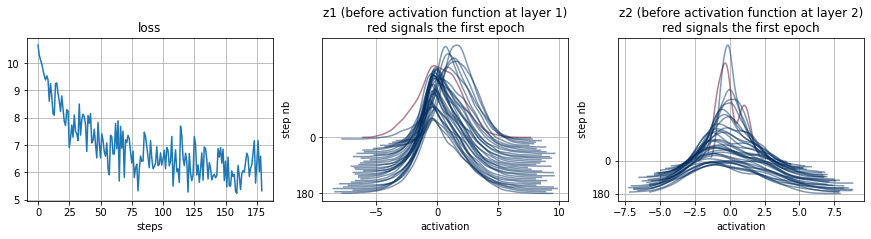

In [2]:
Image("local/imgs/bn1.png")

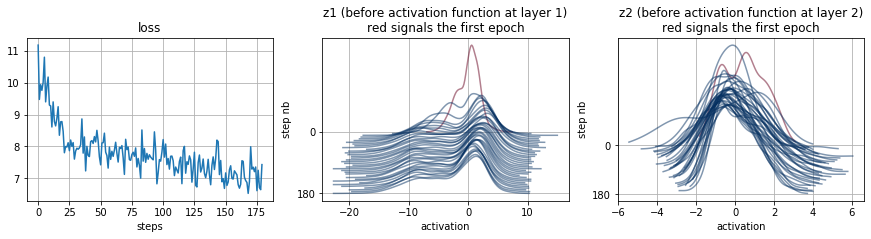

In [3]:
Image("local/imgs/bn2.png")

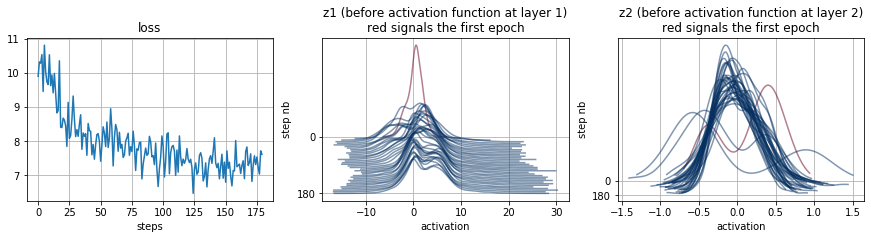

In [5]:
Image("local/imgs/bn1+bn2.png")

# Task 2: Implement BN using TF High Level API

create the exact same network structure using the Sequential or Functional API with the help of `https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization`

log the **loss**, **accuracy** and **weights histograms** to tensorboard.

include screen shots of your tensorboard experiments.

# Task 3 (optional): use [`tf.summary`](https://www.tensorflow.org/api_docs/python/tf/summary) to log $z1$ and $z2$ to tensorboard

In [594]:
from tensorflow.keras import Model
from tensorflow.keras.activations import relu, sigmoid, tanh, linear, softmax
from progressbar import progressbar as pbar
from scipy.stats import gaussian_kde

class MyModel(Model):
    def __init__(self, bn1=False, bn2=False):
        super(MyModel, self).__init__()
        self.bn1 = bn1
        self.bn2 = bn2
            
    def build(self, input_shape):
        
        self.w1 = self.add_weight(shape=(input_shape[-1], 100), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b1 = self.add_weight(shape=(100, ), initializer='random_normal', trainable=True, dtype=tf.float32)        
        
        self.w2 = self.add_weight(shape=(100, 3), initializer='random_normal', trainable=True, dtype=tf.float32)
        self.b2 = self.add_weight(shape=(3, ), initializer='random_normal', trainable=True, dtype=tf.float32)        

        
    @tf.function
    def get_z1(self, X):
        return tf.matmul(X,self.w1)+self.b1
                
    @tf.function
    def get_z2(self, X):
        z1 = self.get_z1(X)
        if self.bn1:
            m = tf.reduce_mean(z1)
            s = tf.math.reduce_std(z1)
            z1 = (z1-m)/(s+1e-3)
        a1 = relu(z1)
        return tf.matmul(a1,self.w2)+self.b2
        
    @tf.function
    def call(self, X):
        z2 = self.get_z2(X)
        if self.bn2:
            m = tf.reduce_mean(z2)
            s = tf.math.reduce_std(z2)
            z2 = (z2-m)/(s+1e-3)
        a2 = softmax(z2)
        
        return a2
        
    @tf.function
    def train_step(self, X,y):
        preds = model(X)
        with tf.GradientTape() as tape:
            loss_value = tf.reduce_mean(self.loss(model(X), y))
        grads = tape.gradient(loss_value, self.trainable_variables)

        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return loss_value

    def fit(self, X,y, epochs=10, batch_size=32):
        self.hloss = []
        self.hz1 = []
        self.hz2 = []
        for epoch in pbar(range(epochs)):
            idxs = np.random.permutation(len(X))
            for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
                X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
                y_batch = y[idxs][step*batch_size:(step+1)*batch_size]
                loss_value = self.train_step(X_batch, y_batch)
                self.hz1.append(self.get_z1(X_batch).numpy().flatten())
                self.hz2.append(self.get_z2(X_batch).numpy().flatten())
                self.hloss.append(loss_value)
    
    def score(self, X, y):
        return np.mean(model.predict(X).argmax(axis=1) == y)    
    
    def plot_hist(self):
        def plot_z_history(s):
            s = s[::5]
            for i,data in enumerate(pbar(s)):
                kde = gaussian_kde(data)
                xrange = np.linspace(np.min(data), np.max(data),100)
                plt.plot(xrange, kde(xrange)-i*.005, 
                         color=plt.cm.RdBu(255*i/len(s)), 
                         alpha=.5)
            plt.yticks([0,-i*.005], [0,len(model.hz1)]);
            plt.ylabel("step nb")
            plt.xlabel("activation")
            plt.grid();
        plt.figure(figsize=(15,3))
        plt.subplot(131)
        plt.plot(self.hloss); plt.grid(); plt.title("loss"); plt.xlabel("steps")
        plt.subplot(132)
        plot_z_history(self.hz1); plt.title("z1 (before activation function at layer 1)\nred signals the first epoch")
        plt.subplot(133)
        plot_z_history(self.hz2); plt.title("z2 (before activation function at layer 2)\nred signals the first epoch")

In [595]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy


100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
  2% (1 of 36) |                         | Elapsed Time: 0:00:00 ETA:  00:00:00

train accuracy 0.539
test  accuracy 0.515


100% (36 of 36) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (36 of 36) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


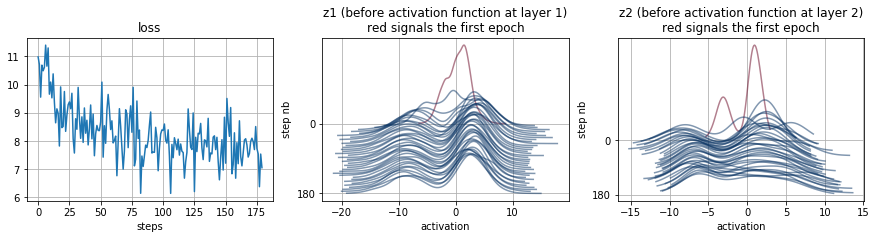

In [596]:
model = MyModel()
model.compile(optimizer="adam", loss=categorical_crossentropy)
model.fit(x_trainf, np.eye(3)[y_train.astype(int)], epochs=10, batch_size=128)
print ("train accuracy %.3f"%model.score(x_trainf, y_train))
print ("test  accuracy %.3f"%model.score(x_testf, y_test))
model.plot_hist()

100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
  2% (1 of 36) |                         | Elapsed Time: 0:00:00 ETA:  00:00:00

train accuracy 0.656
test  accuracy 0.597


100% (36 of 36) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (36 of 36) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


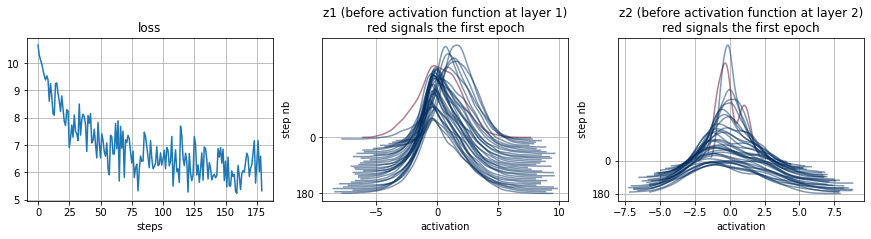

In [597]:
model = MyModel(bn1=True)
model.compile(optimizer="adam", loss=categorical_crossentropy)
model.fit(x_trainf, np.eye(3)[y_train.astype(int)], epochs=10, batch_size=128)
print ("train accuracy %.3f"%model.score(x_trainf, y_train))
print ("test  accuracy %.3f"%model.score(x_testf, y_test))
model.plot_hist()    

100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
N/A% (0 of 36) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

train accuracy 0.673
test  accuracy 0.622


100% (36 of 36) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (36 of 36) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


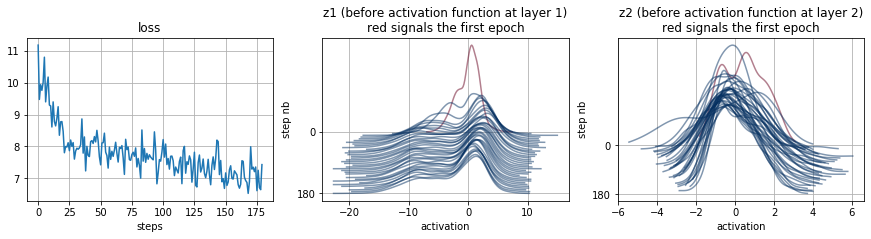

In [598]:
model = MyModel(bn2=True)
model.compile(optimizer="adam", loss=categorical_crossentropy)
model.fit(x_trainf, np.eye(3)[y_train.astype(int)], epochs=10, batch_size=128)
print ("train accuracy %.3f"%model.score(x_trainf, y_train))
print ("test  accuracy %.3f"%model.score(x_testf, y_test))
model.plot_hist() 

100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
  5% (2 of 36) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:01

train accuracy 0.692
test  accuracy 0.632


100% (36 of 36) |########################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (36 of 36) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


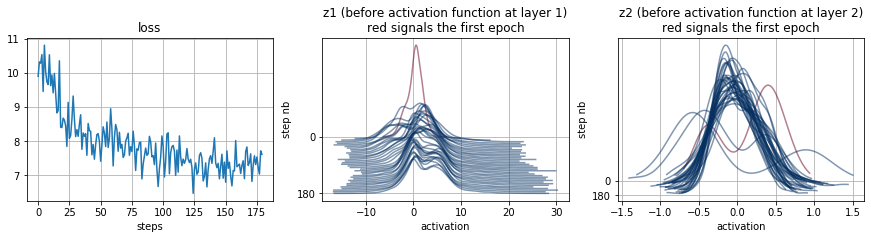

In [599]:
model = MyModel(bn1=True, bn2=True)
model.compile(optimizer="adam", loss=categorical_crossentropy)
model.fit(x_trainf, np.eye(3)[y_train.astype(int)], epochs=10, batch_size=128)
print ("train accuracy %.3f"%model.score(x_trainf, y_train))
print ("test  accuracy %.3f"%model.score(x_testf, y_test))
model.plot_hist() 